# Normalized Baseline

After testing, the most idealized spectrogram settings were selected and various normalization procedures tried, and adjust range came out on top for validation set performance metrics. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Create Database

In [2]:
main_folder = r'E:\baseline-w-normalization'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-normalized.json'
recipe_file = main_folder + '\\' + 'resnet_recipe-1.json'
pos_folder = r'E:\baseline-w-normalization\annots\pos'
neg_folder = r'E:\baseline-w-normalization\annots\neg'
file_durations_file = r'E:\baseline-w-normalization\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'rs-db-normalized.h5'
model_name = main_folder + '\\' + 'normalized.kt'
temp_folder = main_folder + '\\' + 'rs-temp'

data_folder = r'D:\ringed-seal-data'

In [3]:
# Get list of all csv files in positives annot folder 
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals) + ', total: ' + str(sum(ulu2022_vals)))
print('ulu vals (tr, va, te): ' + str(ulu_vals) + ', total: ' + str(sum(ulu_vals)))
print('kk vals (tr, va, te): ' + str(kk_vals) + ', total: ' + str(sum(kk_vals)))
print('cb vals (tr, va, te): ' + str(cb_vals) + ', total: ' + str(sum(cb_vals)))

ulu22 vals (tr, va, te): [1037, 296, 143], total: 1476
ulu vals (tr, va, te): [669, 191, 95], total: 955
kk vals (tr, va, te): [1348, 384, 192], total: 1924
cb vals (tr, va, te): [133, 38, 19], total: 190


In [4]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [5]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [6]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
train.to_csv(main_folder + '\\' + 'train.csv', index=False)
print(len(train))
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

cleaning training table of original length 6374
Number of rows to drop (note, one entry may be in list twice): 10
6362
cleaning training table of original length 1818
Number of rows to drop (note, one entry may be in list twice): 4
1813
cleaning training table of original length 898
Number of rows to drop (note, one entry may be in list twice): 2
894


In [7]:
train.to_csv(main_folder + '\\' + 'train.csv')
val.to_csv(main_folder + '\\' + 'val.csv')
test.to_csv(main_folder + '\\' + 'test.csv')

In [8]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:50<00:00, 37.41it/s]


6362 items saved to E:\baseline-w-normalization\rs-db-normalized.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:44<00:00, 41.10it/s]


1813 items saved to E:\baseline-w-normalization\rs-db-normalized.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:21<00:00, 41.53it/s]

894 items saved to E:\baseline-w-normalization\rs-db-normalized.h5


## Train Classifier

In [15]:
#model_names = [main_folder + '\\' + 'rs-model-0.kt', main_folder + '\\' + 'rs-model-1.kt', main_folder + '\\' + 'rs-model-2.kt', 
#              main_folder + '\\' + 'rs-model-3.kt', main_folder + '\\' + 'rs-model-4.kt', main_folder + '\\' + 'rs-model-5.kt',
#              main_folder + '\\' + 'rs-model-6.kt', main_folder + '\\' + 'rs-model-7.kt', main_folder + '\\' + 'rs-model-8.kt',
#              main_folder + '\\' + 'rs-model-9.kt', main_folder + '\\' + 'rs-model-10.kt']

#temp_folders = [main_folder + '\\' + 'rs-temp-0', main_folder + '\\' + 'rs-temp-1', main_folder + '\\' + 'rs-temp-2', main_folder + '\\' + 'rs-temp-3', main_folder + '\\' + 'rs-temp-4',
#               main_folder + '\\' + 'rs-temp-5', main_folder + '\\' + 'rs-temp-6', main_folder + '\\' + 'rs-temp-7', main_folder + '\\' + 'rs-temp-8', main_folder + '\\' + 'rs-temp-9',
#               main_folder + '\\' + 'rs-temp-10']

#np_seeds = [1736, 680, 1996, 1522, 867, 543, 249, 707, 584, 1236, 161]
#tf_seeds = [1660, 977, 1396, 1456, 1539, 673, 1743, 1492, 1776, 1273, 394]

In [13]:
model_names = [main_folder + '\\' + 'rs-model-0-noenhance.kt']

temp_folders = [main_folder + '\\' + 'rs-temp-0-noenhance']

np_seeds = [1736]
tf_seeds = [1660]

In [14]:
for idx, model in enumerate(model_names):

        # Set the random seed for numpy and tensorflow 
        np.random.seed(np_seeds[idx])
        tf.random.set_seed(tf_seeds[idx])
        
        # Set the batch size and number of epochs for training
        batch_size = 16
        n_epochs = 40
        
        # Set the log folder and checkpoint folder 
        log_folder = main_folder + '\\' + 'logs-no-enhance' + str(idx)
        checkpoint_folder = main_folder + '\\' + 'checkpoints-no-enhance' + str(idx)
        
        # Open the database file in read mode
        db = dbi.open_file(db_name, 'r')
        
        # Open the training and validation tables respectively 
        train_data = dbi.open_table(db, "/train/data")
        val_data = dbi.open_table(db, "/val/data")
        
        # Create batches of training data of size batch size, using the specified data table 
        # This returns indices of the data in each batch along with their labels 
        train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                            output_transform_func=ResNetInterface.transform_batch,
                                            shuffle=True, refresh_on_epoch_end=True)
        
        # Create batches of validation data of size batch size, using the specified data table 
        # This returns indices of the data in each batch along with their labels 
        val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                           output_transform_func=ResNetInterface.transform_batch,
                                           shuffle=False, refresh_on_epoch_end=False)
        
        # Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
        resnet = ResNetInterface.build(recipe_file)
        
        # Set the training and validation generators to the batch generators created above 
        resnet.train_generator = train_generator
        resnet.val_generator = val_generator
        
        # Set the model log and checkpoint directory 
        resnet.log_dir = log_folder
        resnet.checkpoint_dir = checkpoint_folder
        
        # Train the model, looping through all of the training and validation data 
        # See code map for more information
        resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log-' + str(idx) +'.csv')
        
        # Close the database 
        db.close()
        
        # Save the model file, and keep track of the spectrogram parameters used to generate that model 
        resnet.save(model, audio_repr_file=spectro_file)
        
        print('Done training model # ' + str(idx))

Done training model # 0


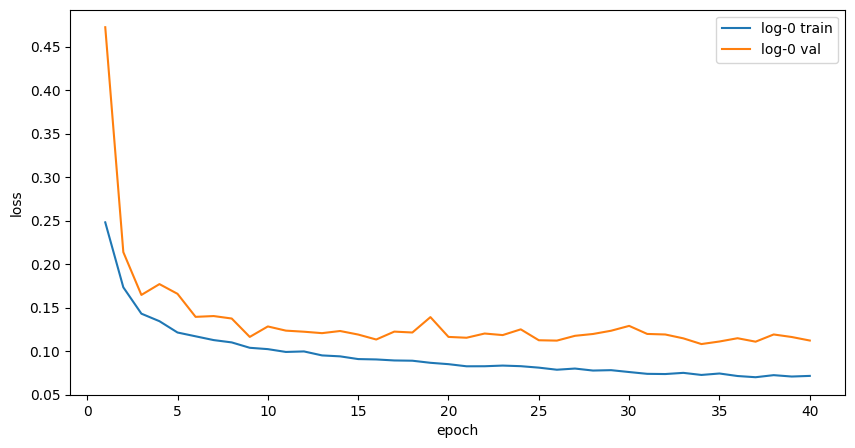

In [15]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-w-normalization\logs-no-enhance0'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

## Deploy Detector

In [16]:
def compute_detections(labels, scores, threshold):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [17]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

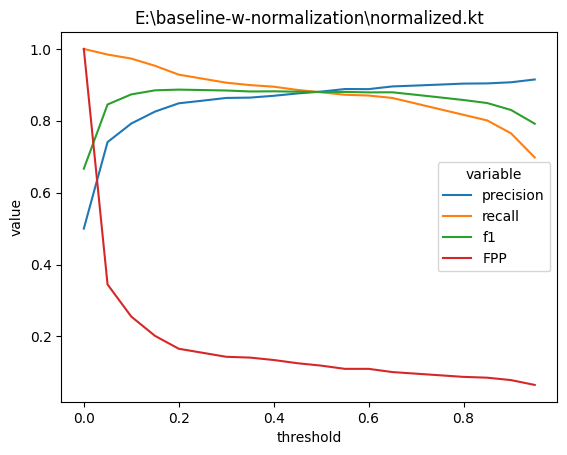

In [18]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\metrics-no-enhance'
main_folder = r'E:\baseline-w-normalization'
db_name = main_folder + '\\' + 'rs-db-normalized.h5'
temp_folder = main_folder + '\\' + 'temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

for idx, model in enumerate(model_names):

    classification_csv = "classifications-" + str(idx) + ".csv"
    metric_csv = "metrics-" + str(idx) + ".csv"
    stats_csv = "stats-" + str(idx) + ".csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model_name)
    
    db.close()

Confusion Matrix


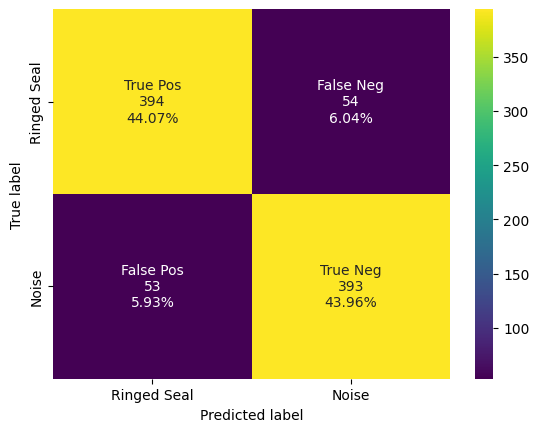

In [19]:
threshold = 0.5

classifications_file = r'E:\baseline-w-normalization\metrics-no-enhance\classifications-0.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## Deploy on Pearce Point Data

### Create a Pearce Point Database

In [20]:
pp_folder = r'E:\baseline-w-normalization\pp'
db_name = pp_folder + '\\' r'pierce_point_db.h5'
spectro_file = r'E:\baseline-w-normalization\spec_config_100-1200Hz-0.032-hamm-normalized.json'
data_folder = r'D:\ringed-seal-data'

pp_pos = pd.read_csv(r'E:\baseline-w-normalization\annots\pos\PP_all_formatted_1sec.csv')
pp_pos2 = pp_pos.ffill()
pp_pos2 = sl.standardize(table=pp_pos2, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(pp_pos2)))

pp_neg = pd.read_csv(r'E:\baseline-w-normalization\annots\neg\PP-negs-joined.csv')
pp_neg2 = pp_pos.ffill()
pp_neg2 = sl.standardize(table=pp_neg2, start_labels_at_1=False)
print('Negatives standardized? ' + str(sl.is_standardized(pp_neg2)))

pp_all = pd.concat([pp_pos2, pp_neg2])

Positives standardized? True
Negatives standardized? True


In [21]:
pp_all.to_excel(pp_folder + '\\' + 'all_pp_annots.xlsx')

In [22]:
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=pp_all, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:12<00:00, 13.61it/s]

168 items saved to E:\baseline-w-normalization\pp\pierce_point_db.h5


### Apply Model to Pearce Point Database

In [25]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\pp\metrics'
main_folder = r'E:\baseline-w-normalization\pp'
db_name = r'E:\final-baseline-detector\pearce-point\pp-all.h5'
temp_folder = main_folder + '\\' + 'temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

for idx, model in enumerate(model_names):

    classification_csv = "classifications-" + str(idx) + ".csv"
    metric_csv = "metrics-" + str(idx) + ".csv"
    stats_csv = "stats-" + str(idx) + ".csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model_name)
    
    db.close()

Attempt to open non-existing table /test in file E:\final-baseline-detector\pearce-point\pp-all.h5 (File) ''
Last modif.: '2024-02-05T18:55:05+00:00'
Object Tree: 
/ (RootGroup) ''
/train (Group) ''
/train/data (Table(168,)fletcher32, shuffle, zlib(1)) ''



NoSuchNodeError: group ``/`` does not have a child named ``/test``

<Axes: xlabel='threshold', ylabel='value'>

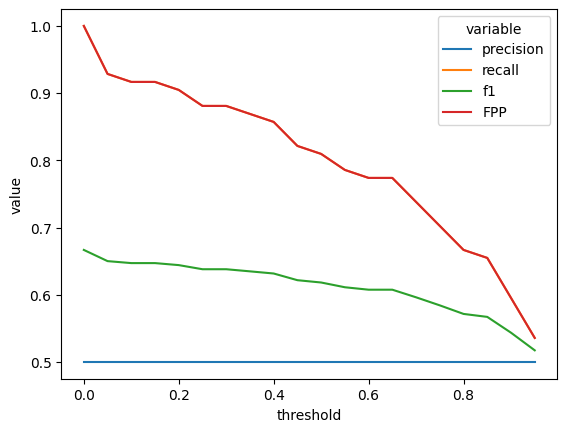

In [21]:
df_stats = pd.read_csv(r'E:\baseline-w-normalization\pp\metrics\stats-4.csv')
sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))

Confusion Matrix


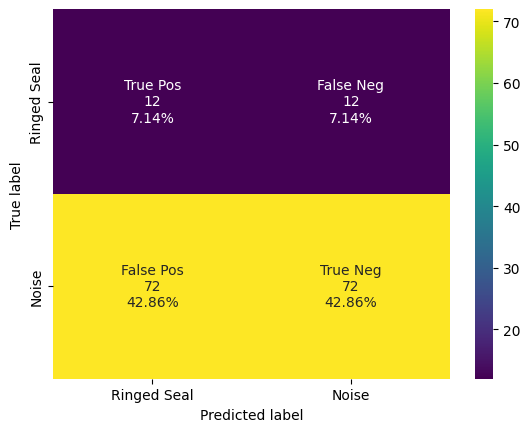

In [22]:
threshold = 0.4

classifications_file = r'E:\baseline-w-normalization\pp\metrics\classifications-4.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

### Deploy on Audio Data

In [25]:
pp_all_ri = pd.read_excel(r'E:\baseline-w-normalization\pp\all_pp_annots.xlsx')
pp_allf = pp_all_ri.ffill()

audio_folder = r'E:\baseline-w-normalization\pp\audio'

for idex, row in pp_allf.iterrows():
    shutil.copyfile(pp_allf.loc[idex]['filename'], audio_folder + '\\' + pp_allf.loc[idex]['filename'].split('\\')[-1])

print('done')

done


In [30]:
temp_folder = pp_folder + '\\' + 'ringedS_tmp_folder'
detections_csv = pp_folder + '\\' + 'detections_raw.csv'
threshold = 0
step_size = 1.0
batch_size = 16
buffer = 0.5 
model_for_pp = r'E:\baseline-w-normalization\rs-model-4.kt'

audio_folder = r'E:\baseline-w-normalization\pp\audio'

model = ResNetInterface.load(model_file=model_for_pp, new_model_folder=temp_folder)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

  0%|                                                                                          | 0/299 [00:00<?, ?it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 46 samples were padded on the left and 0 samples were padded on the right


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:47<00:00,  6.23it/s]


In [37]:
results_table = detections

#results_table = results_table[results_table.inc != 'Y']
#results_table = results_table[results_table.label == 1]

cols = ['filename']
results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
results_table['Selection'] = results_table.index +1
results_table['View'] = 'Spectrogram 1'
results_table['Channel'] = 1
results_table['Begin Path'] = r'E:\baseline-w-normalization\pp\audio' + '\\' + results_table.filename
results_table['File Offset (s)'] = results_table.start
results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
results_table['Begin File'] = results_table['Begin File']
results_table['Low Freq (Hz)'] = 100
results_table['High Freq (Hz)'] = 1200

results_table.to_csv(pp_folder + '\\' + 'raven_formatted_results.txt', index=False, sep='\t')

## Fine-Tuning with Pearce Point

In [39]:
ft_folder = r'E:\baseline-w-normalization\pp\fine-tune'
pp_pos = pd.read_csv(r'E:\baseline-w-normalization\annots\pos\PP_all_formatted_1sec.csv')
pp_neg = pd.read_csv(r'E:\baseline-w-normalization\annots\neg\PP-negs-joined.csv')

# Create a database
db_name = r'E:\baseline-w-normalization\pp\fine-tune\pp-split.h5'
data_folder = r'D:\ringed-seal-data'

## Create Database ##
# negatives tables and standarize for ketos
pp_neg = pp_neg.ffill()
pp_neg_tr_val = round(len(pp_neg)*.85)
pp_neg_te_val = len(pp_neg) - pp_neg_tr_val

pp_neg_tr_num = round(pp_neg_tr_val*0.85)
pp_neg_va_num = pp_neg_tr_val - round(pp_neg_tr_val*0.85)

pp_neg_tr = pp_neg.head(pp_neg_tr_num)
pp_neg_val = pp_neg[pp_neg_tr_num:pp_neg_tr_num+pp_neg_va_num]
pp_neg_te = pp_neg.tail(pp_neg_te_val)

pp_neg_tr = sl.standardize(table=pp_neg_tr)
pp_neg_val = sl.standardize(table=pp_neg_val)
pp_neg_te = sl.standardize(table=pp_neg_te)

pp_pos = pp_pos.ffill()

pp_pos_tr = pp_pos.head(pp_neg_tr_num)
pp_pos_val = pp_pos[pp_neg_tr_num:pp_neg_tr_num+pp_neg_va_num]
pp_pos_te = pp_pos.tail(pp_neg_te_val)

pp_pos_tr = sl.standardize(table=pp_pos_tr, start_labels_at_1=True)
pp_pos_val = sl.standardize(table=pp_pos_val, start_labels_at_1=True)
pp_pos_te = sl.standardize(table=pp_pos_te, start_labels_at_1=True)

pp_tr = pd.concat([pp_pos_tr, pp_neg_tr])
pp_val = pd.concat([pp_pos_val, pp_neg_val])
pp_te = pd.concat([pp_pos_te, pp_neg_te])

spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=pp_tr, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=pp_val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=pp_te, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 65.33it/s]


120 items saved to E:\baseline-w-normalization\pp\fine-tune\pp-split.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.93it/s]


22 items saved to E:\baseline-w-normalization\pp\fine-tune\pp-split.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.58it/s]

26 items saved to E:\baseline-w-normalization\pp\fine-tune\pp-split.h5


In [40]:
main_folder = r'E:\baseline-w-normalization\pp\fine-tune'
pretrained_model = r'E:\baseline-w-normalization\rs-model-4.kt'
new_model = main_folder + '\\' + 'pearce-point-fine-tuned-model.kt'

# Set the random seed for numpy and tensorflow
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 100

# Set the log folder and checkpoint folder
log_folder = main_folder + '\\' + 'logs'
checkpoint_folder = main_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/test/data")

# Create batches of training data of size batch size, using the specified data table
# This returns indices of the data in each batch along with their labels
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Load the pretrained model, replacing the top (aka. classification layers). This method inherently freezes the base.
resnet = ResNetInterface.load(pretrained_model, replace_top=True)

# Set the training and validation generators to the batch generators created above
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# digging into their scripts for fine tuning
# resnet.py, "clone with new top"

# Train the model, looping through all of the training and validation data
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=True)
#resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=False)

# Close the database
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model
resnet.save(new_model, audio_repr_file=spectro_file)

print('Done')

Done


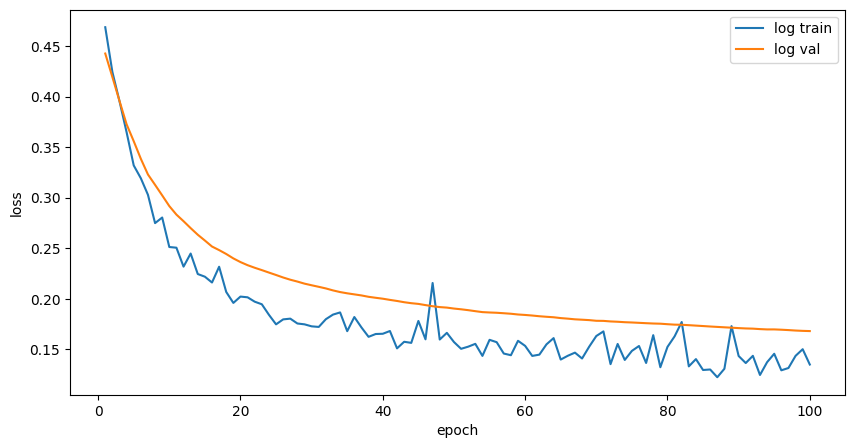

In [41]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-w-normalization\pp\fine-tune\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

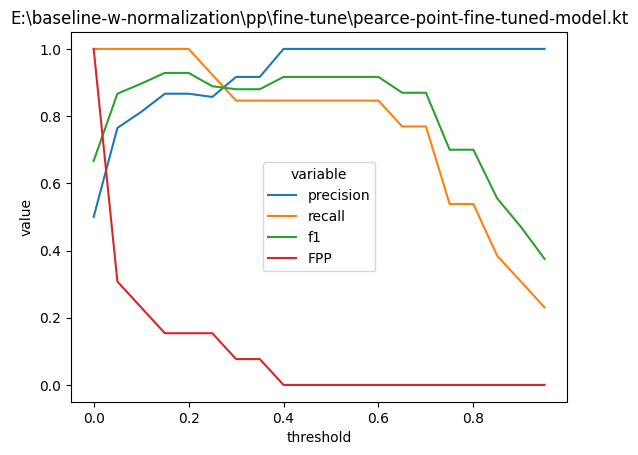

In [57]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\pp\fine-tune\metrics'
main_folder = r'E:\baseline-w-normalization\pp\fine-tune'
db_name = r'E:\baseline-w-normalization\pp\fine-tune\pp-split.h5'
model_name = r'E:\baseline-w-normalization\pp\fine-tune\pearce-point-fine-tuned-model.kt'
temp_folder = r'E:\baseline-w-normalization\pp\fine-tune\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications-ft.csv"
metric_csv = "metrics-ft.csv"
stats_csv = "stats-ft.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)
 
db.close()

Confusion Matrix


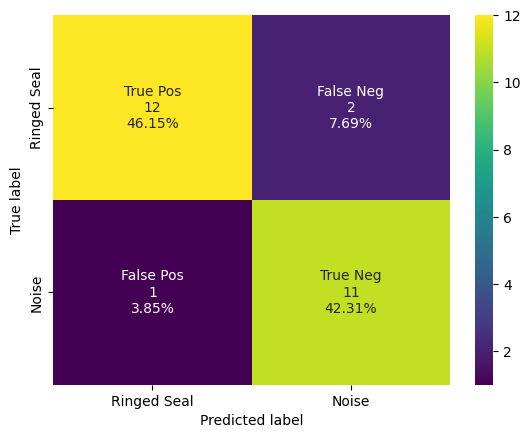

In [58]:
threshold = 0.3

classifications_file = r'E:\baseline-w-normalization\pp\fine-tune\metrics\classifications-ft.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

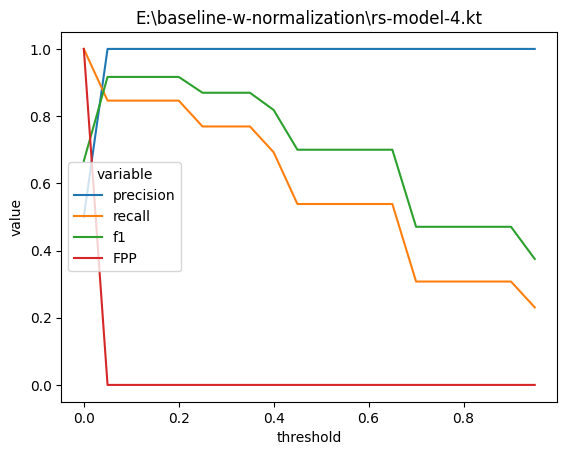

In [59]:
# Apply the old model for comparison

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\pp\fine-tune\metrics'
main_folder = r'E:\baseline-w-normalization\pp\fine-tune'
db_name = r'E:\baseline-w-normalization\pp\fine-tune\pp-split.h5'
model_name = r'E:\baseline-w-normalization\rs-model-4.kt'
temp_folder = r'E:\baseline-w-normalization\pp\fine-tune\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications-notpt.csv"
metric_csv = "metrics-notpt.csv"
stats_csv = "stats-notpt.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


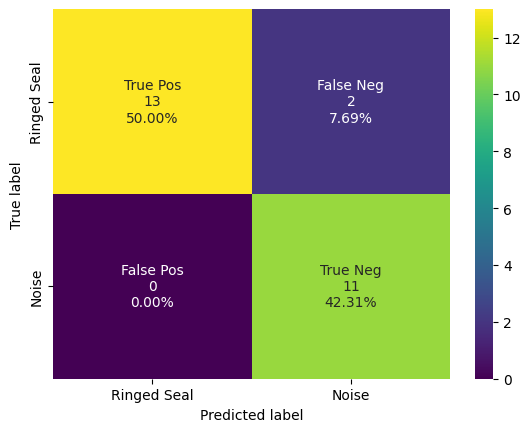

In [54]:
threshold = 0.1
classifications_file = r'E:\baseline-w-normalization\pp\fine-tune\metrics\classifications-notpt.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

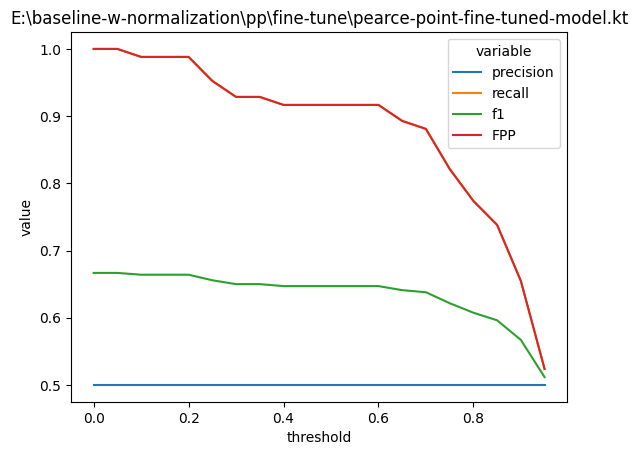

In [61]:
# Apply the old model for comparison

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\pp\fine-tune\metrics'
main_folder = r'E:\baseline-w-normalization\pp\fine-tune'
db_name = r'E:\baseline-w-normalization\pp\pierce_point_db.h5'
model_name = r'E:\baseline-w-normalization\pp\fine-tune\pearce-point-fine-tuned-model.kt'
#model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\pearce-point-fine-tuned-model.kt'
temp_folder = r'E:\baseline-w-normalization\pp\fine-tune\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications-allpearce.csv"
metric_csv = "metrics-allpearce.csv"
stats_csv = "stats-allpearce.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


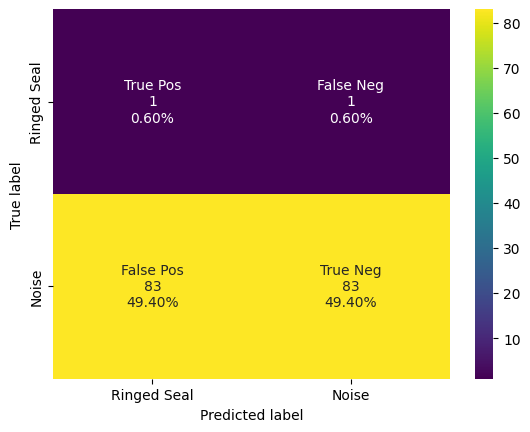

In [56]:
threshold = 0.1
classifications_file = r'E:\baseline-w-normalization\pp\fine-tune\metrics\classifications-allpearce.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')